# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief



You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_predict, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

### 1b. Load the data
Call the variable `cigData`. 

In [186]:
cigData = pd.read_csv('CowboyCigsData.csv', index_col=0)
cigData.head()

,Time,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

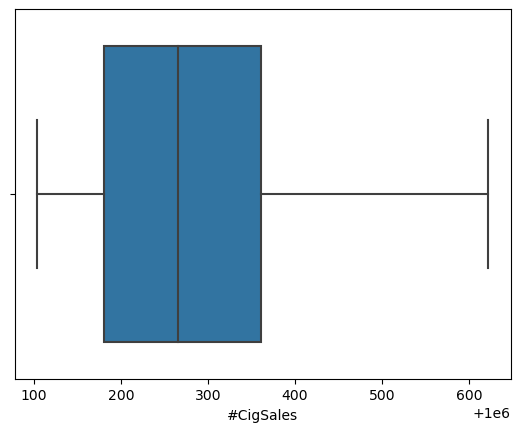

In [11]:
sns.boxplot(x=cigData['#CigSales'])
plt.show()

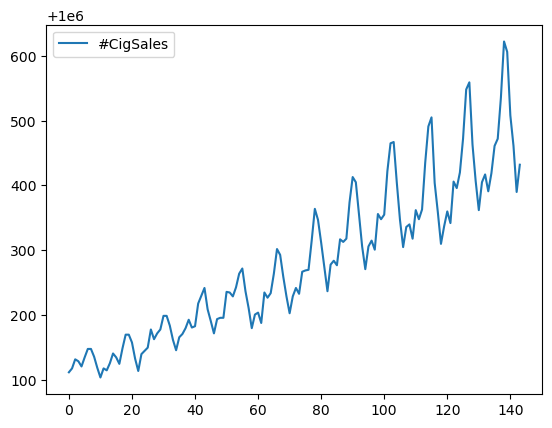

In [12]:
sns.lineplot(cigData)
plt.show()

Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

<font color="green">There are two columns, although the time column will be used as an index"</font>

In [13]:
cigData.columns

Index(['Time', '#CigSales'], dtype='object')

Let's check out the data types of our columns.

In [14]:
cigData.dtypes

Time         object
#CigSales     int64
dtype: object

Check whether there are any null values. 

In [15]:
cigData.isnull().sum()

Time         0
#CigSales    0
dtype: int64

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [16]:
print('dropped using import parameters')

dropped using import parameters


### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [187]:
cigData.rename(columns={'Time':'Month', '#CigSales':'Sales'}, inplace=True)

Call a head() to check this has worked. 

In [4]:
cigData.head()

,Month,Sales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [188]:
cigData['Month'] = pd.to_datetime(cigData['Month'])

In [189]:
cigData.set_index('Month',drop=True, inplace=True)

In [190]:
cigData.dtypes

Sales    int64
dtype: object

In [27]:
cigData.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [191]:
y = cigData.Sales

Check the type of our new variable. 

In [29]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [30]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: Sales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

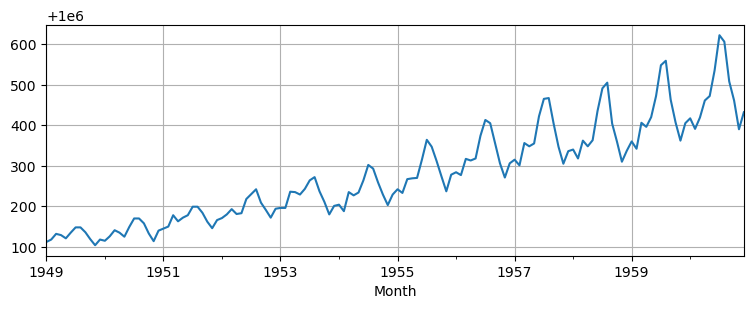

In [35]:
plt.figure(figsize=(9,3))
y.plot()
plt.grid()
plt.show()

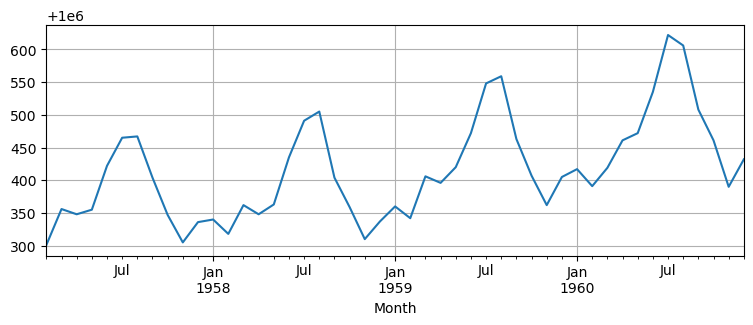

In [43]:
plt.figure(figsize=(9,3))
y[y.index > pd.to_datetime('1957')].plot()
plt.grid()
plt.show()

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

<font color="green">Generally increasing trend over range. Seasonal changes within each year that seem to get more extreme.</font>

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

<font color="green">Lows in Novemeber/December each year, with a January bump. Highs in July/August</font>

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

<font color="green">The sales data is multiplicative</font>

-------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

<font color="green">I tried specifying both `model` parameters. Outputs qualitatively look the same, given the size/scale of the graphs. The magnitude of `seasonal` and `residual` outputs are smaller for the multiplicative model, which makes sense given the nature of the data. However I'm curious about the residual for each model having the same shape, and relationship with year. These thoughts are all without a thorough reading of the `season_decompose` result outputs...</font>

In [63]:
decomposition = seasonal_decompose(y, model='additive')

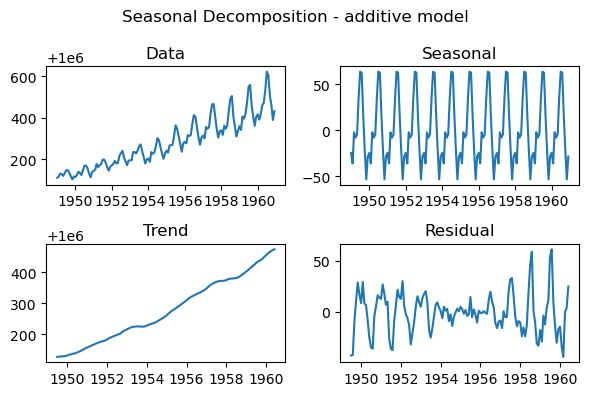

In [64]:
plt.figure(figsize=(6,4), layout='tight')
plt.subplot(2,2,1)
plt.title('Data')
plt.plot(y)

plt.subplot(2,2,2)
plt.title('Seasonal')
plt.plot(decomposition.seasonal)

plt.subplot(2,2,3)
plt.title('Trend')
plt.plot(decomposition.trend)

plt.subplot(2,2,4)
plt.title('Residual')
plt.plot(decomposition.resid)

plt.suptitle('Seasonal Decomposition - additive model')
plt.show()

In [65]:
decomposition = seasonal_decompose(y, model='multiplicative')

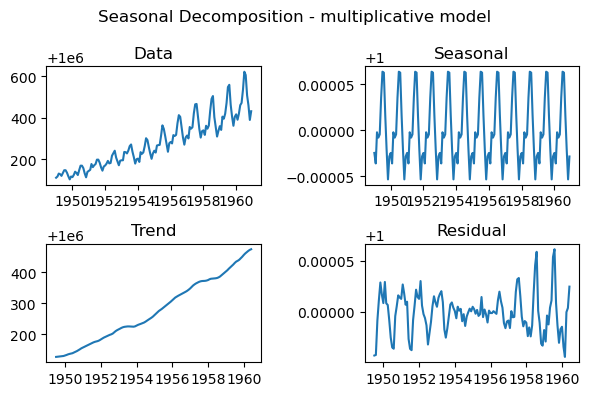

In [66]:
plt.figure(figsize=(6,4), layout='tight')
plt.subplot(2,2,1)
plt.title('Data')
plt.plot(y)

plt.subplot(2,2,2)
plt.title('Seasonal')
plt.plot(decomposition.seasonal)

plt.subplot(2,2,3)
plt.title('Trend')
plt.plot(decomposition.trend)

plt.subplot(2,2,4)
plt.title('Residual')
plt.plot(decomposition.resid)

plt.suptitle('Seasonal Decomposition - multiplicative model')
plt.show()

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [70]:
from statsmodels.tsa.stattools import kpss
kpss(y)[1]

C:\Users\Nish\AppData\Local\Temp\ipykernel_10020\707189343.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss(y)[1]


0.01

Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

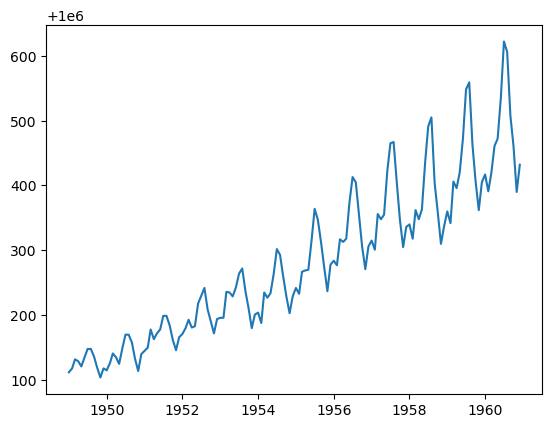

In [72]:
plt.plot(y)
plt.show()

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 


When you plot this, you can see how the variance in our data now remains contant over time.

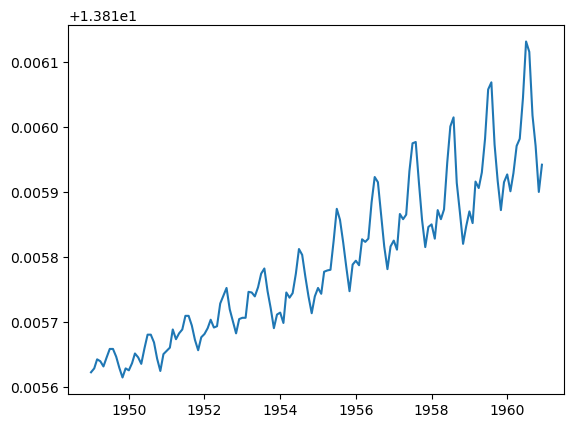

In [77]:
plt.plot(np.log(y))
plt.show()

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [80]:
kpss(np.log(y).diff().dropna())[1]

C:\Users\Nish\AppData\Local\Temp\ipykernel_10020\3963971608.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(np.log(y).diff().dropna())[1]


0.1

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

In [9]:
y_transform = np.log(y).diff().dropna()

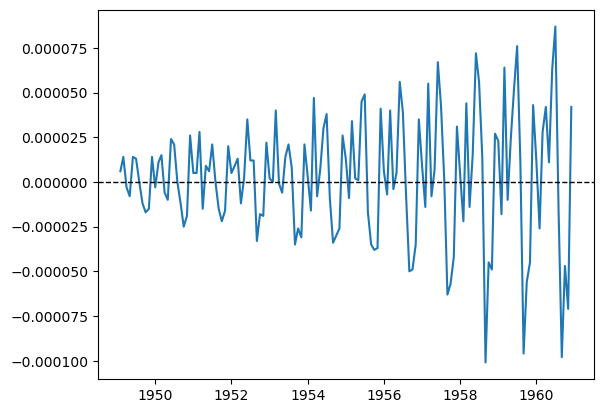

In [13]:
plt.plot(y_transform)
xlims = plt.xlim()
plt.plot(xlims, [0,0], 'k--', linewidth=1)
plt.xlim(xlims)
plt.show()

### 3 interlude - ARIMA, Time Series Review
 - [article ML mastery](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)
 - [article KD nuggets](https://www.kdnuggets.com/2023/08/times-series-analysis-arima-models-python.html#)
   - [referenced Kaggle notebook](https://www.kaggle.com/code/bogdanbaraban/ar-arima-lstm#ARIMA-model)

 - Notes
   - plot autocorrelation vs lags
     - previous month (1) or previous year (12) high
     - start ARIMA model with `p=1`
   - plot train vs. test
     - Tier 1 split procedure is used in articles, could continue with my dataset specific method here
   - order `(p,d,q)`
     - `p` **AR**, number of lagged observations to correlate to current
     - `d` **I**, number of differencing operations to make time series stationary
     - `q` **MA**, size of moving average window used to describe relationship of current observation and residual error
   - can fit to data and then forecast a period, OR do a rolling forecast
     - fit to data, forecast next point, refit to data+predictions, forecast next point . . .

In [15]:
acs = [y.autocorr(lag) for lag in range(1,31)]

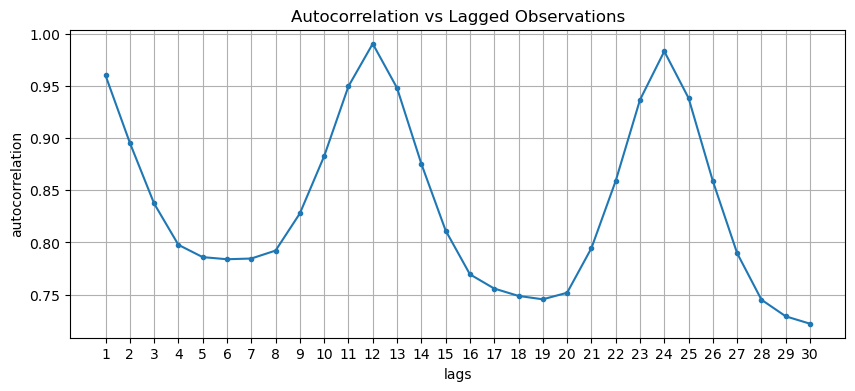

In [25]:
plt.figure(figsize=(10,4))
plt.plot(range(1,31), acs, '.-')
plt.xlabel('lags')
plt.ylabel('autocorrelation')
plt.xticks(range(1,31))
plt.title('Autocorrelation vs Lagged Observations')
plt.grid()

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

[docs](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html#statsmodels.tsa.arima.model.ARIMA)
 - [model object](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html#statsmodels.tsa.arima.model.ARIMA)
   - [fit method](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.fit.html#statsmodels.tsa.arima.model.ARIMA.fit)
 - [fitted model AKA results object](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.html#statsmodels.tsa.arima.model.ARIMAResults)
   - [predict method](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.predict.html#statsmodels.tsa.arima.model.ARIMAResults.predict)
   - [forecast method](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.forecast.html#statsmodels.tsa.arima.model.ARIMAResults.forecast)

In [73]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error

In [36]:
import warnings
warnings.filterwarnings("ignore")

In [194]:
y.to_csv('data.csv')

In [195]:
data = pd.read_csv('data.csv', index_col=0, parse_dates=True)
y = data.Sales

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

<font color="green">
    I reviewed Tier 1 notebook for helps and checks. My guess for splitting the data (before/after cutoff year) seems ok, but not general. Fractional splits should be used in general. I will adopt a rolling forecast method for predictions.<br><br>
    I am not certain about how to handle the data transformations yet and may do some guessing and checking. I settled on sending the raw data to the function, and applying transformations within the function. So the ARIMA model is fit to <code>log(y)</code>, and the exponential of the predictions <code>exp(forecasted_values)</code> is compared to the test set.
</font>

**Test Cells**

In [208]:
# Tried to use .extend method to continuously build fitted results,
# instead of performing full fit each time. Got errors that were not there
# with final forecasting exercise

def arima_score2(model_order, data):
    # split data
    train = data[data.index < pd.to_datetime('1958')]
    test = data.drop(index=train.index)    
    
    # rolling forecast
    prediction = train.copy()
    mod = ARIMA(prediction, order=model_order)
    res = mod.fit(low_memory=True)
    
    while prediction.index.max() <= test.index.max():
        new = res.forecast()
        res = res.extend(new)
        prediction = pd.concat([prediction, new])
        
    # check from previous method
    if prediction.isna().sum() == 0:
        return mean_squared_error(test, prediction[test.index]), res.aic, res.bic
    else:
        return None, None, None

<font color="green">1958 is cutoff for train/test</font>

In [283]:
prediction = train.copy()
mod = ARIMA(train, order=(1,1,0))
res = mod.fit(low_memory=True)

**Data Split**

In [202]:
train = y[y.index < pd.to_datetime('1958')]
test = y.drop(index=train.index)  

In [203]:
train.shape[0]/y.shape[0], test.shape[0]/y.shape[0]

(0.75, 0.25)

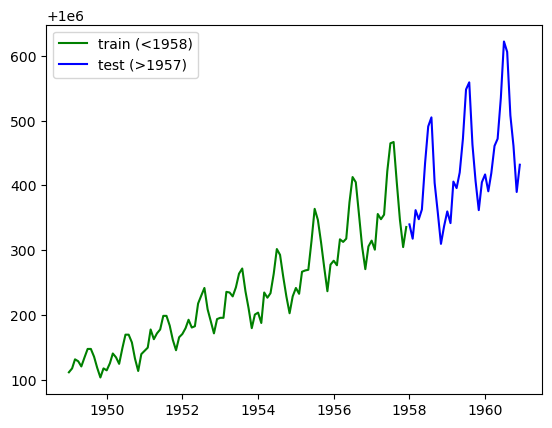

In [204]:
plt.plot(train, 'g')
plt.plot(test, 'b')
plt.legend(['train (<1958)', 'test (>1957)'])
plt.show()

<font color="green">
    Two approaches:<br>
     • rolling forecast<br>
     • rolling forecast, but use former parameter values as start values for subsequent fits
</font>

**2nd approach provides slightly better scores**

**Applying log/exp transformation within score function**

In [501]:
# Instead of using .extend, provide last parameters for each fitted model

def arima_score2(model_order, data):
    # split data
    train = data[data.index < pd.to_datetime('1958')]
    test = data.drop(index=train.index)    
    
    # rolling forecast
    training = np.log(train.copy())
    mod = ARIMA(training, order=model_order)
    res = mod.fit(low_memory=True)
    params = res.params.values
    prediction = res.forecast()
    
    for mo in test.index:
        training = np.log(data[data.index <= mo])
        mod = ARIMA(training, order=model_order)
        res = mod.fit(low_memory=True, start_params=params)
        params = res.params.values
        prediction = pd.concat([prediction, res.forecast()])
        
        
    # check from previous method
    if prediction.isna().sum() == 0:
        return mean_squared_error(test, np.exp(prediction[test.index])), abs(res.aic), abs(res.bic)
    else:
        return None, None, None

In [512]:
# apply transformation within function???

def arima_score(model_order, data):
    # split data
    train = data[data.index < pd.to_datetime('1958')]
    test = data.drop(index=train.index)   
    prediction = pd.Series()
    
    # rolling forecast
    for mo in test.index: 
        training = np.log(data[data.index < mo])
        mod = ARIMA(training, order=model_order)
        res = mod.fit(low_memory=True)
        prediction.loc[mo] = res.forecast()[0]
    
    # check from previous method
    if prediction.isna().sum() == 0:
        return mean_squared_error(test, np.exp(prediction[test.index])), abs(res.aic), abs(res.bic)
    else:
        return None, None, None

In [515]:
arima_score((1,0,0), y), arima_score2((1,0,0), y)

((2604.7557446107003, 2533.8380703091157, 2524.949536418336),
 (2549.9725006703848, 2543.8076974493392, 2534.898257550611))

In [516]:
arima_score((1,1,0), y), arima_score2((1,1,0), y)

((2290.472946490496, 2534.8212227570434, 2528.909568641841),
 (2270.1480709249954, 2547.3623570383675, 2541.4366677778476))

In [517]:
arima_score((1,1,1), y), arima_score2((1,1,1), y)

((2257.693365456387, 2534.647868510284, 2525.78038733748),
 (2222.0652967337874, 2548.669641968789, 2539.7811080780093))

In [518]:
arima_score((2,1,1), y), arima_score2((2,1,1), y)

((2137.4225035343716, 2547.662688336355, 2535.83938010595),
 (2082.477351181301, 2558.568123808084, 2546.716745287044))

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [519]:
from tqdm import tqdm

*Default nesting for progress bars doesn't work well in Jupyter*

In [520]:
def arima_search(data, ps, ds, qs):
    results = pd.DataFrame()
    
    for p in tqdm(ps, desc='ARIMA search'):
        for d in ds:
            for q in qs:
                scores = arima_score2((p,d,q), data)
                results.loc[f'({p},{d},{q})', 'MSE'] = scores[0]
                results.loc[f'({p},{d},{q})', 'AIC'] = scores[1]
                results.loc[f'({p},{d},{q})', 'BIC'] = scores[2]
    
    return results

**ARIMA parameter search with raw data**

In [521]:
%%time

parameter_values = (0,1,2,3)
results = arima_search(y, parameter_values, parameter_values, parameter_values)

ARIMA search: 100%|██████████| 4/4 [03:34<00:00, 53.72s/it]

CPU times: total: 4min 30s
Wall time: 3min 34s


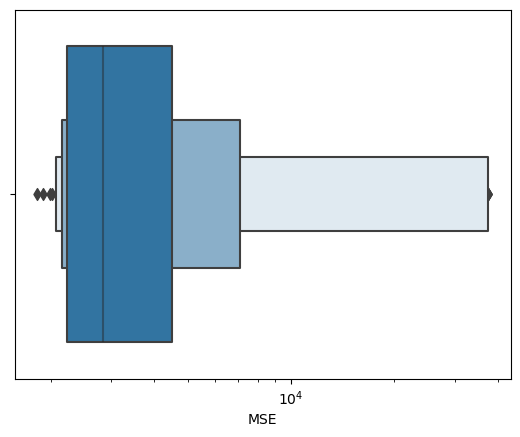

In [522]:
sns.boxenplot(x=results.MSE)
plt.xscale('log')

In [523]:
results.sort_values('MSE').head(15).round().style.background_gradient(subset='MSE', cmap='Purples')

,MSE,AIC,BIC
"(3,1,3)",1827.000000,2566.000000,2546.000000
"(3,1,2)",1891.000000,2566.000000,2548.000000
"(1,1,3)",1987.000000,2558.000000,2543.000000
"(2,1,3)",2019.000000,2553.000000,2535.000000
"(2,1,2)",2074.000000,2554.000000,2539.000000
"(2,1,1)",2082.000000,2559.000000,2547.000000
"(1,1,2)",2096.000000,2553.000000,2541.000000
"(3,1,0)",2127.000000,2555.000000,2544.000000
"(3,1,1)",2156.000000,2552.000000,2537.000000
"(2,0,3)",2172.000000,2563.000000,2542.000000


In [524]:
results.loc['(2,1,1)',:]/results.min()

MSE    1.140014
AIC    1.174807
BIC    1.180635
dtype: float64

<font color="red">This is the closest I've gotten to matching the (2,1,1) result. It is about 10-20% worse than the best scores (3,1,3), (3,1,2), (1,1,3)</font>

So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

<font color="green">I found (3,1,3) or (1,1,3) to be the best orders . . . Will look into how (1,1,3) and (2,1,1) predict test data below.</font>

##### Extra Stuff
*previous attempt updated the training data with predictions, instead of the actual values (during rolling forecast, fit). resulting model predictions were not good*

*now results look good, but shift is still required*

In [525]:
data = y.copy()
test_predictions = {}

for order in [(3,1,3), (1,1,3), (2,1,1)]:

    # split data
    train = data[data.index < pd.to_datetime('1958')]
    test = data.drop(index=train.index)    

    # rolling forecast
    training = np.log(train.copy())
    mod = ARIMA(training, order=order)
    res = mod.fit(low_memory=True)
    params = res.params.values
    prediction = res.forecast()

    for mo in test.index:
        training = np.log(data[data.index <= mo])
        mod = ARIMA(training, order=order)
        res = mod.fit(low_memory=True, start_params=params)
        params = res.params.values
        prediction = pd.concat([prediction, res.forecast()])

    test_predictions[str(order)] = np.exp(prediction)

In [526]:
test_predictions.keys()

dict_keys(['(3, 1, 3)', '(1, 1, 3)', '(2, 1, 1)'])

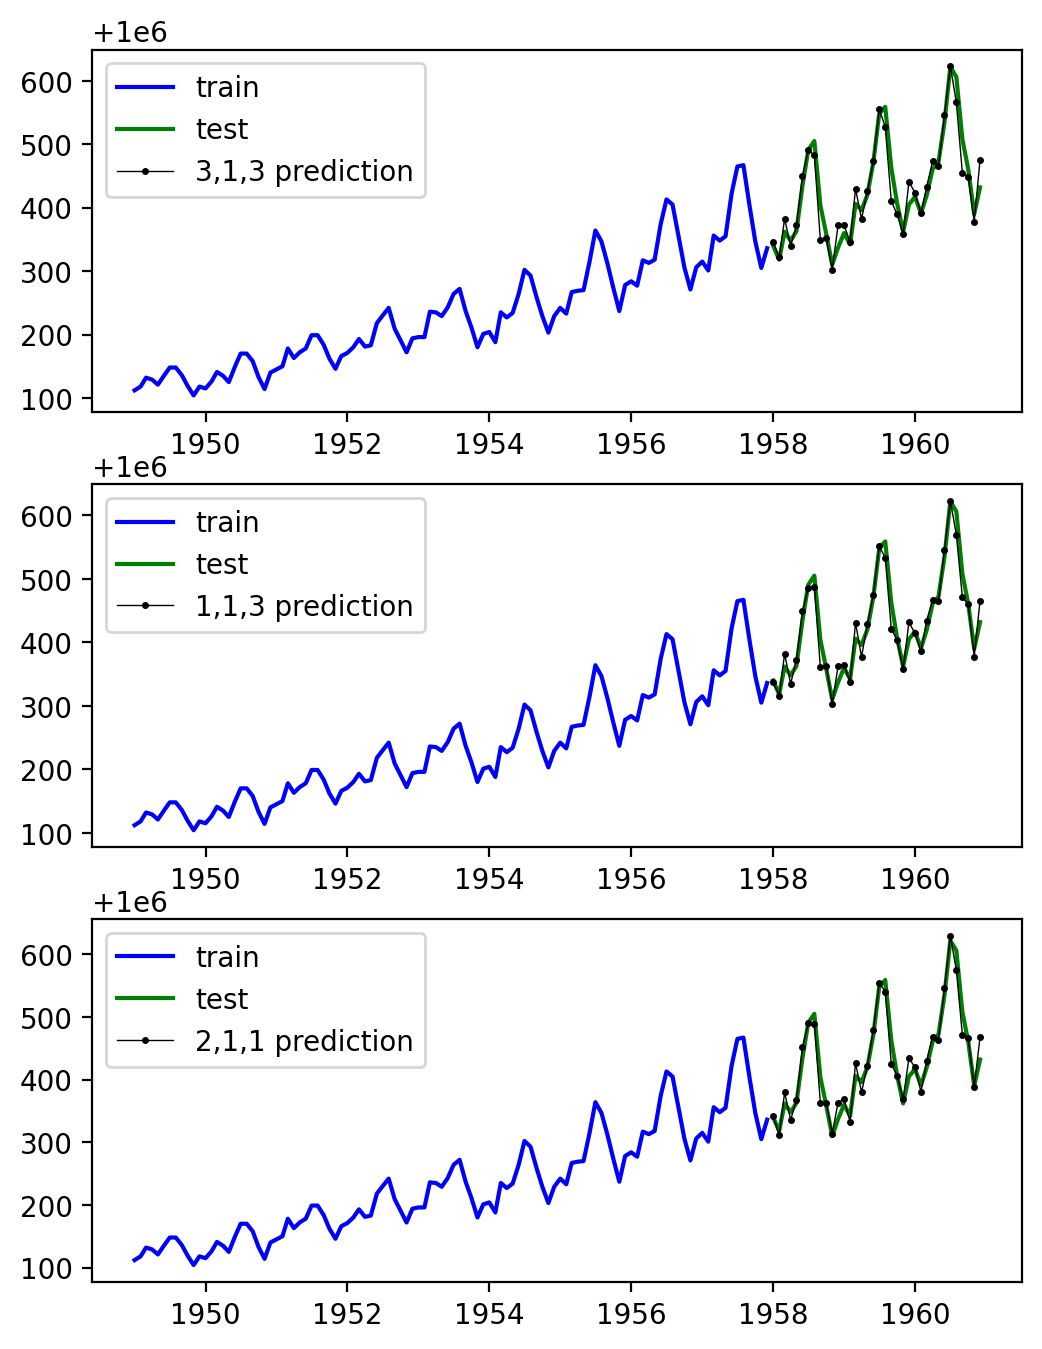

In [536]:
plt.figure(figsize=(6,8), dpi=200)

plt.subplot(311)
plt.plot(train,'b')
plt.plot(test,'g')
plt.plot(test_predictions['(3, 1, 3)'].shift(-1),'k.-', linewidth=0.5, markersize=3)
plt.legend(['train','test', '3,1,3 prediction'])


plt.subplot(312)
plt.plot(train,'b')
plt.plot(test,'g')
plt.plot(test_predictions['(1, 1, 3)'].shift(-1),'k.-', linewidth=0.5, markersize=3)
plt.legend(['train','test', '1,1,3 prediction'])


plt.subplot(313)
plt.plot(train,'b')
plt.plot(test,'g')
plt.plot(test_predictions['(2, 1, 1)'].shift(-1),'k.-', linewidth=0.5, markersize=3)
plt.legend(['train','test', '2,1,1 prediction'])
plt.show()

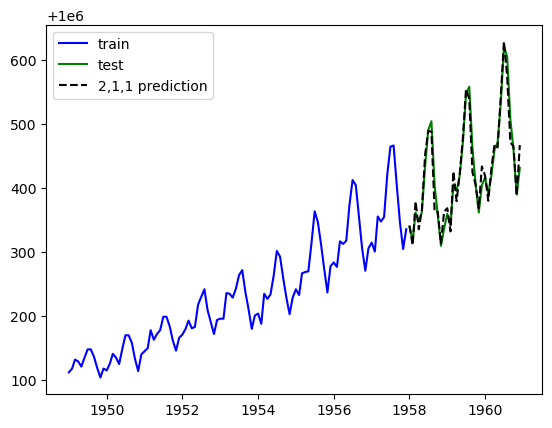

In [537]:
plt.plot(train,'b')
plt.plot(test,'g')
plt.plot(test_predictions['(2, 1, 1)'].shift(-1),'k--')
plt.legend(['train','test', '2,1,1 prediction'])
plt.show()

----

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

In [538]:
mod = ARIMA(y,order=(2,1,1))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  144
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -704.088
Date:                Sat, 25 Nov 2023   AIC                           1416.176
Time:                        17:05:43   BIC                           1428.028
Sample:                    01-01-1949   HQIC                          1420.992
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8280      0.469      1.767      0.077      -0.091       1.747
ar.L2         -0.0587      0.031     -1.887      0.059      -0.120       0.002
ma.L1         -0.7848      0.472     -1.661      0.097      -1.711       0.141
sigma2      1051.1975    119.503      8.796      0.000     816.977    1285.418
===================================================================================
Ljung-Box (L1) (Q):                   9.17   Jarque-Bera (JB):                 3.40
Prob(Q):                              0.00   Prob(JB):                         0.18
Heteroskedasticity (H):               6.73   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

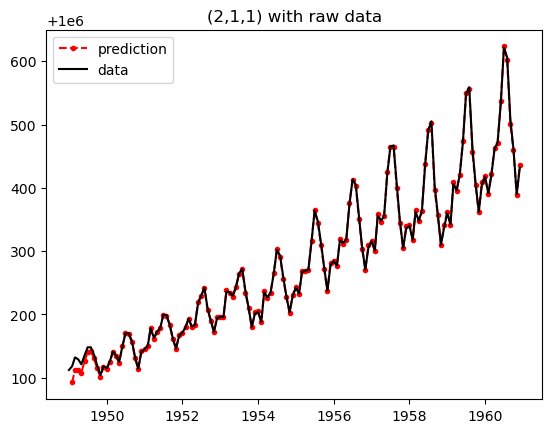

In [540]:
plt.plot(res.predict(start=y.index[1], end='1961-01-01').shift(-1), 'r.--')
plt.plot(y, 'k-')
plt.legend(['prediction', 'data'])
plt.title('(2,1,1) with raw data')
plt.show()

In [541]:
mod = ARIMA(np.log(y),order=(2,1,1))
res = mod.fit()

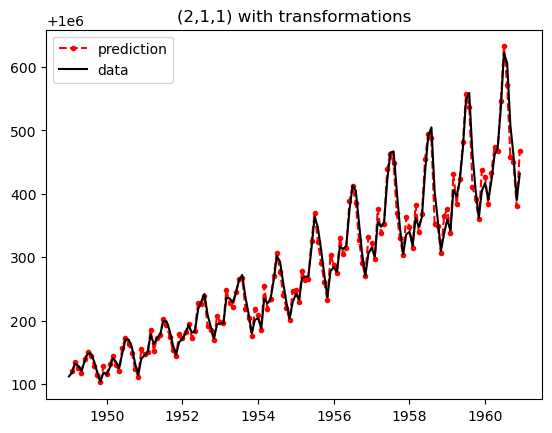

In [542]:
plt.plot(np.exp(res.predict(start=y.index[1], end='1961-01-01').shift(-1)), 'r.--')
plt.plot(y, 'k-')
plt.legend(['prediction', 'data'])
plt.title('(2,1,1) with transformations')
plt.show()

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

<font color="green">I don't think my results look right . . . I fixed one big error in the scoring functions, but I'm not sure if I'm making out-of-range forecasts properly</font>

---

In [552]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_dates = pd.date_range(start='1961', end='1970', freq='MS')

# Convert that range into a dataframe that includes your predictions
mod = ARIMA(y,order=(2,1,1))
res = mod.fit()
forecast1 = [res.predict(mo).values[0] for mo in forecast_dates]

mod = ARIMA(y,order=(2,1,1))
res = mod.fit()
forecast2 = res.forecast(109)

prediction = y.copy()
mod = ARIMA(prediction,order=(2,1,1))
res = mod.fit()
params = res.params.values
for mo in tqdm(forecast_dates):
    new = res.predict(mo)
    prediction = pd.concat([prediction, new])
    mod = ARIMA(prediction, order=(2,1,1))
    res = mod.fit(start_params=params, low_memory=True)
    params = res.params.values

100%|██████████| 109/109 [00:06<00:00, 15.71it/s]


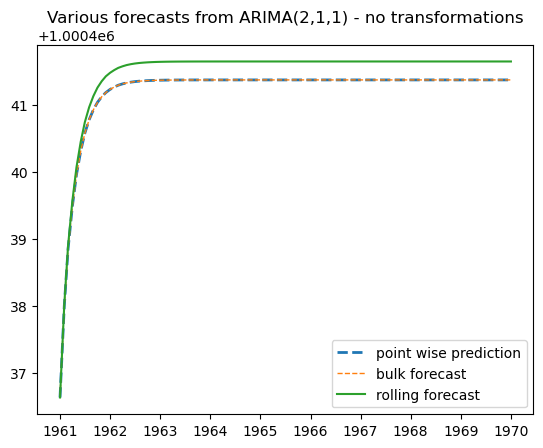

In [553]:
plt.plot(forecast_dates,forecast1, '--', linewidth=2)
plt.plot(forecast2, '--', linewidth=1)
plt.plot(prediction[prediction.index > y.index.max()], '-')
plt.legend(['point wise prediction', 'bulk forecast', 'rolling forecast'])
#plt.yscale('log')
plt.title('Various forecasts from ARIMA(2,1,1) - no transformations')
plt.show()

**with transformation**

In [554]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_dates = pd.date_range(start='1961', end='1970', freq='MS')

# Convert that range into a dataframe that includes your predictions
mod = ARIMA(np.log(y),order=(2,1,1))
res = mod.fit()
forecast1 = [np.exp(res.predict(mo).values[0]) for mo in forecast_dates]

mod = ARIMA(np.log(y),order=(2,1,1))
res = mod.fit()
forecast2 = np.exp(res.forecast(109))

In [555]:
prediction = np.log(y.copy())
mod = ARIMA(prediction,order=(2,1,1))
res = mod.fit()
params = res.params.values


for mo in tqdm(forecast_dates):
    new = res.predict(mo)
    prediction = pd.concat([prediction, new])
    mod = ARIMA(prediction, order=(2,1,1))
    res = mod.fit(start_params=params)
    params = res.params.values
    
prediction = np.exp(prediction)

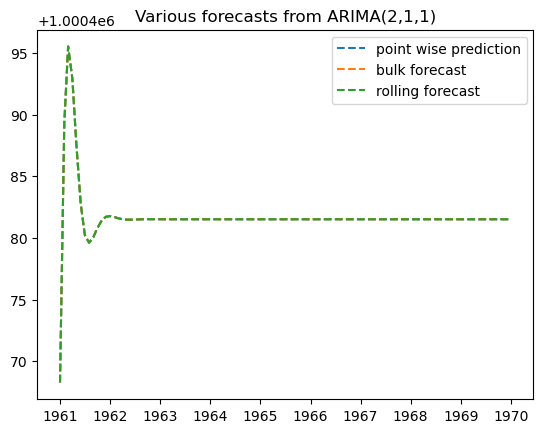

In [556]:
plt.plot(forecast_dates,forecast1, '--')
plt.plot(forecast2, '--')
plt.plot(prediction[prediction.index > y.index.max()], '--')
plt.legend(['point wise prediction', 'bulk forecast', 'rolling forecast'])
#plt.yscale('log')
plt.title('Various forecasts from ARIMA(2,1,1)')
plt.show()

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 